In [1]:
import jax.numpy as jnp

from jaxgp.kernels import RBF
from jaxgp.utils import _CovMatrix_Kernel, _CovMatrix_Grad, _CovMatrix_Hess

import matplotlib.pyplot as plt

## Full cov matrix

In [2]:
num_f_vals = 1
num_d_vals = 3

X = jnp.arange(num_f_vals, dtype=jnp.float32).reshape(-1,1)
# X = jnp.hstack((X,X))

DX = jnp.arange(num_d_vals, dtype=jnp.float32).reshape(-1,1)
# DX = jnp.hstack((DX,DX))


params = jnp.ones(2)
kernel = RBF()

In [3]:
print(X.shape, DX.shape, params, kernel)

(1, 1) (3, 1) [1. 1.] <jaxgp._src.kernels.RBF object at 0x7f5ad8037a90>


In [4]:
cov = _CovMatrix_Kernel(X, X, kernel, params)
dcov = _CovMatrix_Grad(X, DX, kernel, params)
ddcov = _CovMatrix_Hess(DX, DX, kernel, params)

print(cov.shape, dcov.shape, ddcov.shape)

(1, 1) (1, 3, 1) (3, 3, 1, 1)


In [5]:
import jax

flatten = jax.vmap(jnp.ravel, in_axes=0)

In [6]:
f = cov
# old_shape = jnp.array(dcov.shape)
# new_shape = (old_shape[0], jnp.prod(old_shape[1:]))
# d = dcov.reshape(*new_shape)
d = flatten(dcov)
dd = jnp.hstack(jnp.hstack((*ddcov,)))

print(f.shape, d.shape, dd.shape)
# print(f)
# print(d)
# print(dd)

(1, 1) (1, 3) (3, 3)


In [7]:
full = jnp.vstack((jnp.hstack((f,d)),jnp.hstack((d.T,dd))))

In [8]:
print(full.shape)
print(full)

(4, 4)
[[ 1.          0.         -0.60653067 -0.27067056]
 [ 0.          1.         -0.         -0.40600586]
 [-0.60653067 -0.          1.         -0.        ]
 [-0.27067056 -0.40600586 -0.          1.        ]]


In [9]:
x1 = jnp.zeros(1).reshape(1,1)
x2 = jnp.linspace(-2,2,101).reshape(-1,1)

In [10]:
y = _CovMatrix_Kernel(x1, x2, kernel, params)
print(y.shape)
dy = _CovMatrix_Grad(x1, x2, kernel, params)
print(dy.shape)
ddy = _CovMatrix_Hess(x1, x2, kernel, params)
print(ddy.shape)

(1, 101)
(1, 101, 1)
(1, 101, 1, 1)


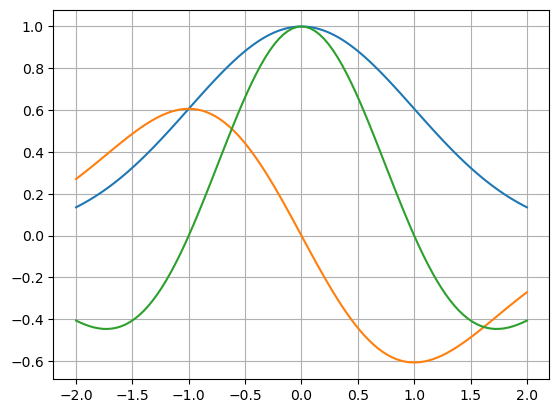

In [11]:
plt.plot(x2, y.reshape(-1))
plt.plot(x2, dy.reshape(-1))
plt.plot(x2, ddy.reshape(-1))
plt.grid()

## Sparse cov matrix

In [12]:
X = jnp.arange(2, dtype=jnp.float32).reshape(2,-1)
X = jnp.hstack((X, X))

X_ref = X

params = jnp.ones(2)
kernel = RBF()

In [13]:
print(X, params, kernel)

[[0. 0.]
 [1. 1.]] [1. 1.] <jaxgp._src.kernels.RBF object at 0x7f5a984eca00>


In [14]:
cov = _CovMatrix_Kernel(X_ref, X, kernel, params)
dcov = _CovMatrix_Grad(X_ref, X, kernel, params)

print(cov.shape, dcov.shape)

(2, 2) (2, 2, 2)


In [15]:
f = cov
d = jnp.hstack((*dcov,))

print(f.shape, d.shape)
print(f)
print(d)

(2, 2) (2, 4)
[[1.         0.36787945]
 [0.36787945 1.        ]]
[[ 0.          0.          0.36787945  0.36787945]
 [-0.36787945 -0.36787945  0.          0.        ]]


In [16]:
full = jnp.vstack((f,d.T))

In [17]:
print(full.shape)
print(full)

(6, 2)
[[ 1.          0.36787945]
 [ 0.36787945  1.        ]
 [ 0.         -0.36787945]
 [ 0.         -0.36787945]
 [ 0.36787945  0.        ]
 [ 0.36787945  0.        ]]


## Other

In [4]:
from dataclasses import dataclass

@dataclass
class Test:
    var1: int
    var2: float

In [5]:
a = Test(1,2)